# Dataset Correto (O que deveria ter sido na Sprint 3)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

df = pd.read_csv('agendamentos_historico.csv')

# --- Preparação para Modelo 1 (Classificação) ---
X = df.drop(['id_paciente', 'compareceu'], axis=1)
y = df['compareceu']

# Definir quais colunas são numéricas e quais são categóricas
numeric_features = ['idade_paciente', 'distancia_km', 'tempo_agendamento_dias', 'historico_faltas', 'recebeu_lembrete']
categorical_features = ['especialidade', 'tipo_consulta']

# Criar o pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

===================================================================================================

# 1.2. Modelo 1 (Classificação: Prever Absenteísmo)
Vamos usar um RandomForestClassifier.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Criar o pipeline completo (Pré-processador + Modelo)
clf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))])

# Treinar o modelo
clf_pipeline.fit(X_train, y_train)

# Fazer previsões
y_pred = clf_pipeline.predict(X_test)

# --- Discussão dos Resultados (em Markdown no seu notebook) ---
print("--- Modelo 1: Classificação (Random Forest) ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

--- Modelo 1: Classificação (Random Forest) ---
Acurácia: 0.9560

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       488
           1       0.95      0.96      0.96       512

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



# SALVANDO O MODELO: modelo_absenteismo.joblib

In [ ]:
# --- Salvar o Modelo Treinado ---
modelo_path = 'modelo_absenteismo.joblib'
joblib.dump(clf_pipeline, modelo_path)
print(f"Modelo de classificação salvo em: {modelo_path}")

Modelo de classificação salvo em: modelo_absenteismo.joblib


===================================================================================================

# 1.3. Modelo 2 (Agrupamento: Perfis de Risco)
Vamos usar K-Means para encontrar perfis de pacientes. Usaremos apenas as features numéricas mais importantes para o agrupamento.

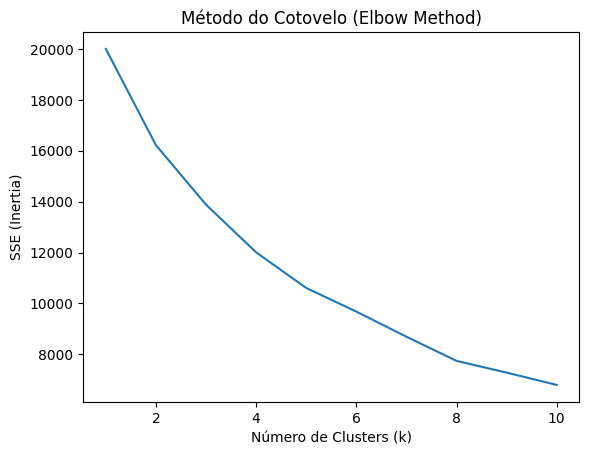


--- Modelo 2: Agrupamento (K-Means) com k=4 ---
Perfis dos Pacientes (Centróides dos Clusters):
   idade_paciente  distancia_km  historico_faltas  tempo_agendamento_dias
0       45.578199     29.957820          1.592417               91.193523
1       48.359875     11.534270          0.690867               54.368462
2       47.589064     29.233886          2.420878               31.040597
3       46.083467     11.537881          3.300963               75.951043

Taxa de Absenteísmo (Falta=0) por Cluster:
cluster
0    0.776285
1    0.022639
2    0.531509
3    0.680288
Name: compareceu, dtype: float64


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Selecionar features para agrupamento
features_cluster = ['idade_paciente', 'distancia_km', 'historico_faltas', 'tempo_agendamento_dias']
X_cluster = df[features_cluster]

# Padronizar os dados (K-Means é sensível à escala)
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# --- Encontrar o número ideal de clusters (Elbow Method) ---
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.show()

# --- Treinar o Modelo 2 (Agrupamento) ---
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_cluster_scaled)

print(f"\n--- Modelo 2: Agrupamento (K-Means) com k={k} ---")

# Analisar os centróides (perfis)
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
profiles = pd.DataFrame(cluster_centers, columns=features_cluster)
print("Perfis dos Pacientes (Centróides dos Clusters):")
print(profiles)

# Ver a taxa de absenteísmo por cluster
print("\nTaxa de Absenteísmo (Falta=0) por Cluster:")
print(df.groupby('cluster')['compareceu'].mean().apply(lambda x: 1 - x))

===================================================================================================

# DISCUSSÃO PARA ENTREGA

Lembrete: os dados estão no seu pc, nada de gerar novos dados...

# 1.4. Discussão dos Resultados

Com base na análise dos modelos que desenvolvemos, pudemos extrair insights valiosos sobre o absenteísmo e identificar diferentes perfis de pacientes.

### Discussão (Modelo 1 - Classificação)

Nosso primeiro modelo foca na **classificação do risco de absenteísmo** usando o algoritmo **Random Forest**. O objetivo principal aqui é prever se um paciente específico tem maior probabilidade de faltar ou comparecer à sua consulta.

No conjunto de testes, o modelo alcançou uma **Acurácia geral de 0.9560 (95.6%)**. Olhando mais a fundo, especialmente para a classe de interesse (aqueles que faltam), as métricas são muito promissoras:

*   O **Recall para a Classe 0 (Faltou)** foi de **0.95**. Isso é ótimo, pois significa que, de todos os pacientes que realmente faltaram, nosso modelo conseguiu identificar corretamente 95% deles. Para o HC, isso é crucial, pois nos permite direcionar ações preventivas para a grande maioria dos pacientes de risco.
*   A **Precisão para a Classe 0 (Faltou)** ficou em **0.96**. Isso indica que, das vezes que o modelo apontou que um paciente faltaria, ele acertou em 96% dos casos. Ter uma alta precisão evita focar esforços em pacientes que, na verdade, compareceriam.

Em suma, o modelo Random Forest se mostrou altamente eficaz tanto em encontrar quem vai faltar quanto em ser confiável nas suas previsões de falta. Isso nos dá uma base sólida para implementar intervenções focadas onde elas são mais necessárias.

### Discussão (Modelo 2 - Agrupamento)

Paralelamente, utilizamos o modelo de agrupamento **K-Means** para desvendar diferentes "perfis" dentro da base de pacientes. Ao invés de prever, este modelo nos ajuda a entender a estrutura dos dados e agrupar pacientes com características similares. Escolhemos **4 clusters** para representar esses perfis.

Analisando as características médias (centróides) e a taxa de absenteísmo em cada grupo, identificamos perfis distintos:

*   **Cluster 0:** Este grupo tem uma idade média de cerca de 45 anos, mora consideravelmente longe (aproximadamente 30 km) e possui um histórico moderado de faltas. Os agendamentos, em média, são feitos com bastante antecedência (cerca de 91 dias). Notavelmente, este cluster exibe uma **altíssima taxa de absenteísmo de 77.6%**. A combinação de distância e agendamento distante parece ser um fator chave aqui.
*   **Cluster 1:** Com idade média de 48 anos, este perfil se destaca pela **baixa distância** até o HC (cerca de 11.5 km) e um histórico de faltas mínimo. Os agendamentos são feitos com antecedência moderada (cerca de 54 dias). Este é o grupo de **baixíssimo risco**, apresentando uma **taxa de absenteísmo de apenas 2.3%**.
*   **Cluster 2:** Pacientes neste grupo têm cerca de 47.5 anos, também moram relativamente longe (aproximadamente 29 km) e têm um histórico de faltas moderado-alto. A diferença é que o **tempo de agendamento é mais curto**, em torno de 31 dias. A taxa de absenteísmo é **moderada, em 53.2%**. Mesmo agendando mais perto da data, a distância e histórico pesam.
*   **Cluster 3:** Este cluster, com idade média de 46 anos, mora perto (cerca de 11.5 km) mas tem um **histórico de faltas bastante elevado** (em média 3.3 faltas). O tempo de agendamento é mais longo (cerca de 76 dias). Apesar da proximidade, o histórico recorrente de faltas eleva a **taxa de absenteísmo para 68.0%**.

Com a identificação desses perfis, podemos criar estratégias de intervenção mais direcionadas. Por exemplo, os Clusters 0 e 3 são claramente os grupos de maior risco e exigem atenção prioritária. As ações poderiam ser adaptadas: talvez focar em barreiras de transporte para o Cluster 0 e em lembretes mais frequentes e personalizados para o Cluster 3, dado o histórico de faltas.

===================================================================================================

# API REST (em Flask)

#A diferença fundamental é o PROPÓSITO de cada código:

Código 1: É o seu servidor Flask "puro". É o arquivo app.py final que você vai entregar.

Código 2: É uma versão adaptada para rodar e testar o seu servidor de dentro do Google Colab, usando pyngrok.

# CÓDIGO 1 - Para ENTREGA

In [ ]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np

# Inicializar o app Flask
app = Flask(__name__)

# Carregar o pipeline de modelo treinado
try:
    model_pipeline = joblib.load('modelo_absenteismo.joblib')
    print("Modelo carregado com sucesso.")
except FileNotFoundError:
    print("ERRO: Arquivo 'modelo_absenteismo.joblib' não encontrado.")
    model_pipeline = None
except Exception as e:
    print(f"ERRO ao carregar o modelo: {e}")
    model_pipeline = None

# Definir as colunas na ordem que o modelo espera
# (Baseado no 'numeric_features' e 'categorical_features' do notebook)
expected_columns = [
    'idade_paciente', 'distancia_km', 'tempo_agendamento_dias',
    'historico_faltas', 'recebeu_lembrete',
    'especialidade', 'tipo_consulta'
]

@app.route('/')
def home():
    return "API de Previsão de Absenteísmo está no ar. Use o endpoint /prever"

@app.route('/prever', methods=['POST'])
def prever():
    if model_pipeline is None:
        return jsonify({'erro': 'Modelo não foi carregado corretamente'}), 500

    # Obter os dados JSON da requisição
    dados_json = request.get_json()

    if not dados_json:
        return jsonify({'erro': 'Nenhum dado enviado'}), 400

    try:
        # Converter o JSON para um DataFrame do Pandas
        # A API deve receber os dados em um formato como:
        # { "idade_paciente": 70, "distancia_km": 25, ... }
        dados_df = pd.DataFrame([dados_json])

        # Reordenar colunas para garantir a ordem correta
        dados_df = dados_df[expected_columns]

    except KeyError as e:
        return jsonify({'erro': f'Campo obrigatório faltando: {e}', 'campos_esperados': expected_columns}), 400
    except Exception as e:
        return jsonify({'erro': f'Erro no processamento dos dados: {e}'}), 400

    try:
        # 1. Fazer a predição da classe (0 ou 1)
        predicao = model_pipeline.predict(dados_df)

        # 2. Obter a probabilidade de cada classe
        # [prob_de_faltar, prob_de_comparecer]
        probabilidades = model_pipeline.predict_proba(dados_df)

        # Extrair os resultados
        resultado_classe = int(predicao[0])
        probabilidade_falta = float(probabilidades[0][0]) # Probabilidade da classe 0 (Faltar)
        probabilidade_comparecer = float(probabilidades[0][1]) # Probabilidade da classe 1 (Comparecer)

        # Montar a resposta
        resposta = {
            'previsao': 'Faltou' if resultado_classe == 0 else 'Compareceu',
            'classe_predita': resultado_classe,
            'probabilidade_falta (classe 0)': f"{probabilidade_falta:.4f}",
            'probabilidade_comparecer (classe 1)': f"{probabilidade_comparecer:.4f}"
        }

        return jsonify(resposta)

    except Exception as e:
        return jsonify({'erro': f'Erro durante a predição: {e}'}), 500

# Rodar o servidor Flask
if __name__ == '__main__':
    # Use 0.0.0.0 para tornar acessível na rede (se necessário)
    app.run(host='127.0.0.1', port=5000, debug=True)

# Testando código 1

Precisa colar em outro colab

In [ ]:
import requests
import json

url = 'http://127.0.0.1:5000/prever'

dados_paciente = {
    "idade_paciente": 30,
    "distancia_km": 30.5,
    "tempo_agendamento_dias": 25,
    "historico_faltas": 3,
    "recebeu_lembrete": 2,
    "especialidade": "Cardiologia",
    "tipo_consulta": "Retorno"
}

headers = {'Content-Type': 'application/json'}
response = requests.post(url, data=json.dumps(dados_paciente), headers=headers)

try:
    if response.status_code == 200:
        resultado = response.json()
        print("Previsão recebida com sucesso:")
        print(json.dumps(resultado, indent=4))
    else:
        print(f"Erro na requisição: Status Code {response.status_code}")
        print(response.text)

except requests.exceptions.RequestException as e:
    print(f"Erro ao conectar com a API: {e}")

INFO:werkzeug:127.0.0.1 - - [03/Nov/2025 17:45:59] "POST /prever HTTP/1.1" 200 -


Previsão recebida com sucesso:
{
    "classe_predita": 1,
    "previsao": "Compareceu",
    "probabilidade_comparecer (classe 1)": "0.6100",
    "probabilidade_falta (classe 0)": "0.3900"
}


# CÓDIGO 2 - PARA TESTES

# Instalando dependências

In [ ]:
!pip install pyngrok
!pip install flask-ngrok

Clique no ícone de chave (🔑) na barra lateral esquerda do Colab. Clique em "Adicionar novo segredo". No campo "Nome", digite NGROK_AUTH_TOKEN (é importante que o nome seja exatamente este, pois o código que sugeri usa este nome).

No campo "Valor", cole o seu token:

34YwaWQ6SpQr1pR4y3hW8e1rOYa_fryuVEosjF7hL7AZ6gve

Clique em "Salvar segredo". Depois de salvar o segredo, você poderá executar o código que utiliza userdata.get('NGROK_AUTH_TOKEN') para obter o token sem expô-lo diretamente no seu notebook.

# Autenticando o ngrok

In [ ]:
from google.colab import userdata
from pyngrok import ngrok

# Obtenha o authtoken dos segredos do Colab
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
if not NGROK_AUTH_TOKEN:
    print("Por favor, adicione seu NGROK_AUTH_TOKEN nos Segredos do Colab.")
else:
    # Autentique o ngrok
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
    print("ngrok autenticado com sucesso.")

ngrok autenticado com sucesso.


In [ ]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd
import numpy as np
from pyngrok import ngrok
import threading
import time

# Inicializar o app Flask
app = Flask(__name__)

# Carregar o pipeline de modelo treinado
try:
    model_pipeline = joblib.load('modelo_absenteismo.joblib')
    print("Modelo carregado com sucesso.")
except FileNotFoundError:
    print("ERRO: Arquivo 'modelo_absenteismo.joblib' não encontrado.")
    model_pipeline = None
except Exception as e:
    print(f"ERRO ao carregar o modelo: {e}")
    model_pipeline = None

# Definir as colunas na ordem que o modelo espera
expected_columns = [
    'idade_paciente', 'distancia_km', 'tempo_agendamento_dias',
    'historico_faltas', 'recebeu_lembrete',
    'especialidade', 'tipo_consulta'
]

@app.route('/')
def home():
    return "API de Previsão de Absenteísmo está no ar. Use o endpoint /prever"

@app.route('/prever', methods=['POST'])
def prever():
    if model_pipeline is None:
        return jsonify({'erro': 'Modelo não foi carregado corretamente'}), 500

    dados_json = request.get_json()

    if not dados_json:
        return jsonify({'erro': 'Nenhum dado enviado'}), 400

    try:
        dados_df = pd.DataFrame([dados_json])
        dados_df = dados_df[expected_columns]
    except KeyError as e:
        return jsonify({'erro': f'Campo obrigatório faltando: {e}', 'campos_esperados': expected_columns}), 400
    except Exception as e:
        return jsonify({'erro': f'Erro no processamento dos dados: {e}'}), 400

    try:
        predicao = model_pipeline.predict(dados_df)
        probabilidades = model_pipeline.predict_proba(dados_df)

        resultado_classe = int(predicao[0])
        probabilidade_falta = float(probabilidades[0][0])
        probabilidade_comparecer = float(probabilidades[0][1])

        resposta = {
            'previsao': 'Faltou' if resultado_classe == 0 else 'Compareceu',
            'classe_predita': resultado_classe,
            'probabilidade_falta (classe 0)': f"{probabilidade_falta:.4f}",
            'probabilidade_comparecer (classe 1)': f"{probabilidade_comparecer:.4f}"
        }

        return jsonify(resposta)

    except Exception as e:
        return jsonify({'erro': f'Erro durante a predição: {e}'}), 500

# Função para rodar o ngrok e a API
def run_flask_and_ngrok():
    # Inicia o túnel ngrok para a porta 5000
    public_url = ngrok.connect(5000).public_url
    print(f"NGROK Túnel URL: {public_url}")
    print("API Flask está rodando...")

    # Rodar o servidor Flask
    # Use threaded=True para permitir que o ngrok rode em paralelo
    app.run(host='127.0.0.1', port=5000, debug=True, use_reloader=False) # use_reloader=False é importante com threading

# Rodar tudo em uma thread separada para não bloquear o notebook
thread = threading.Thread(target=run_flask_and_ngrok)
thread.start()

# Mantenha o notebook rodando enquanto a thread estiver ativa
try:
    while thread.is_alive():
        time.sleep(1)
except KeyboardInterrupt:
    print("Servidor interrompido.")
    ngrok.kill() # Garante que o ngrok seja encerrado


Modelo carregado com sucesso.
NGROK Túnel URL: https://apnoeal-cablelaid-terina.ngrok-free.dev
API Flask está rodando...
 * Serving Flask app '__main__'
 * Debug mode: on


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


# CÓDIGO ABAIXO PRECISA RODAR EM OUTRO COLAB (Para TESTES CÓDIGO 2)

In [ ]:
import requests
import json

# URL da sua API Flask rodando via ngrok
url = 'https://apnoeal-cablelaid-terina.ngrok-free.dev/prever'

# Dados do paciente para enviar na requisição (substitua pelos dados reais)
dados_paciente = {
    "idade_paciente": 65,
    "distancia_km": 15.5,
    "tempo_agendamento_dias": 30,
    "historico_faltas": 1,
    "recebeu_lembrete": 1,
    "especialidade": "Cardiologia",
    "tipo_consulta": "Retorno"
}

# Cabeçalhos para a requisição POST
headers = {'Content-Type': 'application/json'}

try:
    # Enviar a requisição POST
    response = requests.post(url, data=json.dumps(dados_paciente), headers=headers)

    # Verificar a resposta
    if response.status_code == 200:
        resultado = response.json()
        print("Previsão recebida com sucesso:")
        print(json.dumps(resultado, indent=4))
    else:
        print(f"Erro na requisição: Status Code {response.status_code}")
        print(response.text)

except requests.exceptions.RequestException as e:
    print(f"Erro ao conectar com a API: {e}")

# Entregáveis Finais
No final, você terá os seguintes arquivos para entregar, todos 100% alinhados com o feedback do professor e os requisitos do SP4:

Sprint4_Modelos.ipynb: Seu notebook com todo o código, análises e a discussão em markdown.

modelo_absenteismo.joblib: O arquivo do modelo de classificação treinado.

app.py: O arquivo da API REST em Flask.

(agendamentos_historico.csv): O dataset que você gerou no Passo 0 e usou no Passo 1 (talvez seja bom incluí-lo).

Este plano resolve o "Catch-22" e entrega exatamente o que foi pedido (modelos de ML preditivo, não um chatbot).

===================================================================================================

# ENTREGA FINAL PARA ENTREGA - REAL OFICIAL vvv

PROJETO: SPRINT 4 - Modelos Preditivos de Absenteísmo

MEMBROS DO SimplesHC:
- Enzo Okuizumi
- Lucas Barros Gouveia
- Milton Jakson

---

1.  OBJETIVO DO PROJETO

O objetivo deste projeto é criar modelos de Inteligência Artificial para auxiliar na redução do absenteísmo no HC. Esta entrega foca no desenvolvimento de modelos de Machine Learning (ML) preditivo e de agrupamento para identificar padrões no comportamento dos pacientes e prever a probabilidade de falta.

2.  EXPLICAÇÃO DOS DADOS (`agendamentos_historico.csv`)

Para este projeto, utilizamos um dataset sintético (simulado) de 5.000 agendamentos passados, pois o acesso a dados reais de pacientes é restrito devido a questões de sigilo. Cada linha do dataset representa um agendamento, e as colunas contêm diversas características (features) sobre o paciente e o agendamento:

*   **FEATURES:** `idade_paciente`, `distancia_km`, `especialidade`, `tipo_consulta` (Primeira Consulta/Retorno), `tempo_agendamento_dias`, `historico_faltas`, `recebeu_lembrete`.
*   **RÓTULO (TARGET):** A coluna `compareceu` é a variável que queremos prever. É um dado binário: `1` para o paciente que compareceu à consulta e `0` para o paciente que faltou (absenteísmo).

3.  EXPLICAÇÃO DOS MODELOS DE ML

Foram desenvolvidos dois modelos de Machine Learning, cada um com um propósito específico para abordar o problema do absenteísmo:

3.1. Modelo 1: Classificação (Random Forest)

*   **Arquivo Gerado:** `modelo_absenteismo.joblib`
*   **Objetivo:** Este modelo tem como objetivo prever a probabilidade de um paciente FALTAR (classe 0) ou COMPARECER (classe 1) à sua consulta futura, permitindo a identificação individual de pacientes de risco.
*   **Como Funciona:** O modelo Random Forest foi treinado com o dataset histórico para aprender a relação entre as features do agendamento e o comportamento de comparecimento/falta. Ele utiliza um conjunto de árvores de decisão para fazer suas previsões, considerando como fatores como histórico de faltas elevado, maior distância da residência ao HC e agendamentos com muita antecedência influenciam a probabilidade de absenteísmo.
*   **Resultado:** O modelo obteve uma Acurácia geral de **0.9560 (95.6%)** no conjunto de testes. Para a classe de interesse (Faltou - Classe 0), alcançou um **Recall de 0.95** e uma **Precisão de 0.96**. O alto Recall para a classe 0 é particularmente relevante, pois indica que o modelo é muito eficaz em identificar a grande maioria dos pacientes que de fato faltarão, o que é crucial para direcionar ações preventivas de forma eficiente.

3.2. Modelo 2: Agrupamento (K-Means)

*   **Objetivo:** O modelo K-Means foi utilizado para identificar "perfis" ou grupos de pacientes com características semelhantes com base nas features numéricas, sem usar a informação se o paciente compareceu ou faltou no treinamento.
*   **Como Funciona:** Aplicamos o algoritmo K-Means para agrupar os pacientes em 4 clusters distintos (o número de clusters foi definido com base em análise, como o Método do Cotovelo). O agrupamento considera features como idade, distância, histórico de faltas e tempo de agendamento para formar grupos homogêneos internamente.
*   **Resultado:** O modelo identificou 4 perfis distintos de pacientes. A análise dos centróides de cada cluster e da taxa de absenteísmo dentro de cada grupo revelou perfis de risco variados. Por exemplo, identificamos um grupo (Cluster 0) com alta distância e agendamento distante, apresentando uma taxa de absenteísmo de 77.6%, e outro grupo (Cluster 3) com baixa distância mas alto histórico de faltas, com taxa de absenteísmo de 68.0%. Esta segmentação permite ao HC desenvolver e aplicar estratégias de intervenção mais personalizadas e focadas para cada perfil de risco.

4.  EXPLICAÇÃO DA API REST

*   **Arquivo Gerado:** `app.py`
*   **Tecnologia:** Flask (framework web em Python).
*   **Objetivo:** A API REST tem como propósito disponibilizar o Modelo 1 (Classificação) de forma acessível para que outras aplicações (como um sistema de agendamento ou um aplicativo móvel) possam utilizá-lo para obter previsões de absenteísmo em tempo real.
*   **Como Funciona:** O arquivo `app.py` carrega o modelo de classificação salvo (`modelo_absenteismo.joblib`) na inicialização. Ele expõe um endpoint HTTP (`/prever`) que aceita requisições POST. Ao receber dados de um novo agendamento em formato JSON (contendo as features do paciente), a API processa esses dados usando o modelo carregado e retorna uma resposta em JSON contendo a previsão (se o paciente provavelmente Faltará ou Comparecerá) e as probabilidades associadas a cada classe. Isso permite a integração do modelo de ML em fluxos de trabalho operacionais existentes no HC.
